From Anton paper

https://epjc.epj.org/articles/epjc/abs/2024/02/10052_2024_Article_12469/10052_2024_Article_12469.html


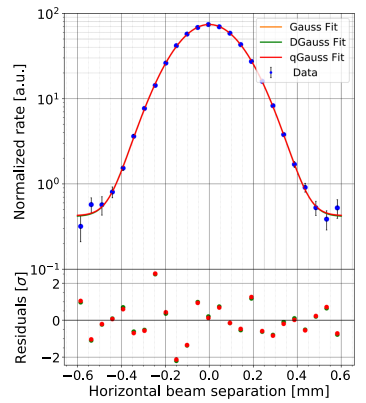

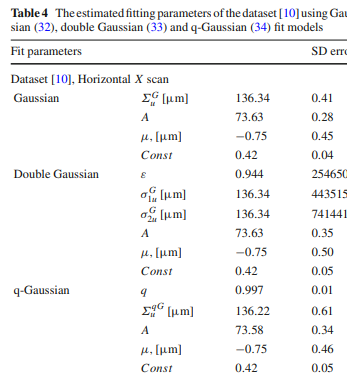

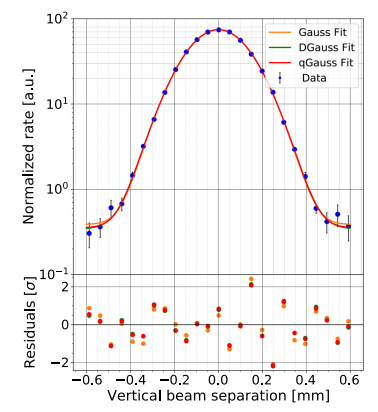

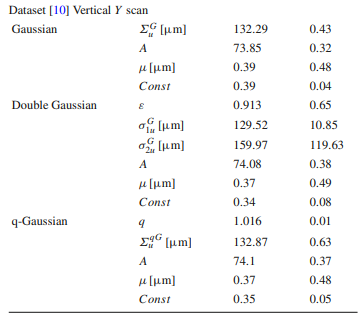

# Pseudo Code

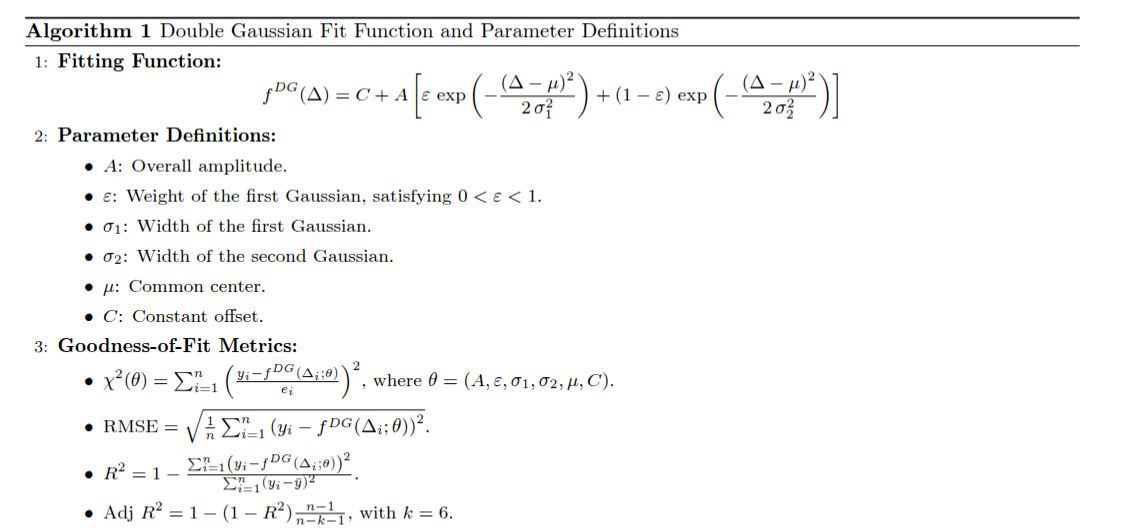

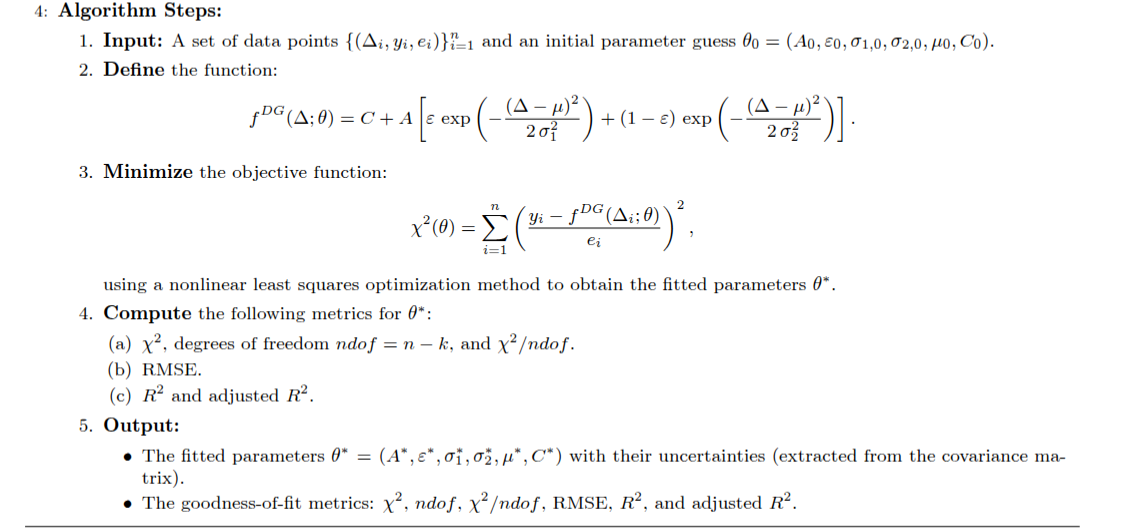

# Data X and Y

Analyzing X-type scan:
[0.09526293 0.10048065 0.12156238 0.10260161 0.08764563 0.15808329
 0.19687626 0.2274511  0.32737281 0.39260799 0.453508   0.47324445
 0.48264412 0.48470798 0.45621598 0.37377783 0.29905039 0.23737111
 0.20306531 0.14007353 0.1181145  0.09440773 0.08756188 0.08626098
 0.11357541]


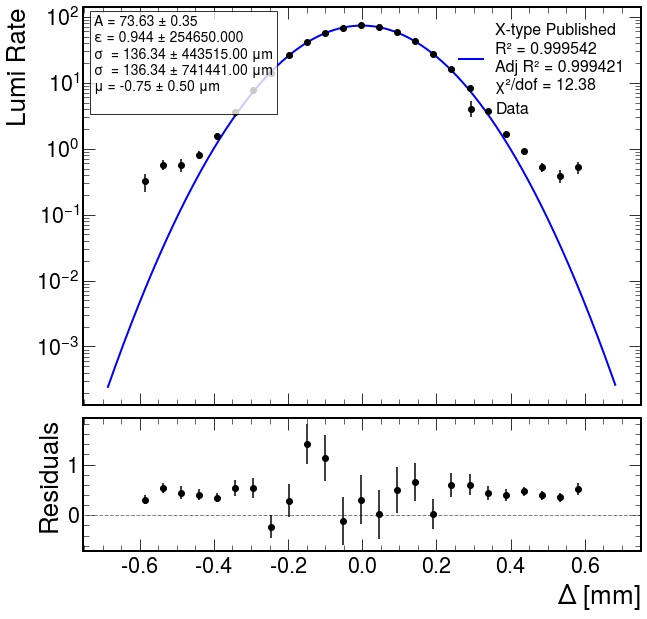

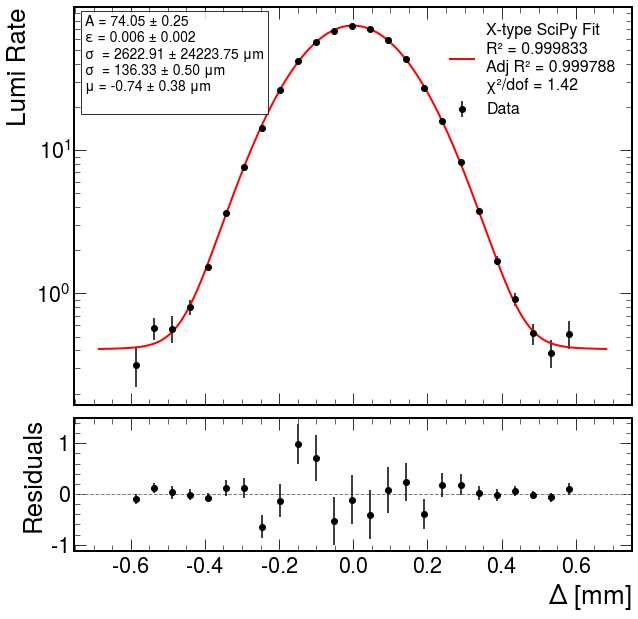


Comparison Table for X-type Scan:
Parameter       Published       Pub SD    SciPy Fit       Fit SD      Δ (Fit-Pub)         Δ SD
----------------------------------------------------------------------------------------------
A                   73.63         0.35        74.05         0.25             0.42         0.10
ε                    0.94    254650.00         0.01         0.00            -0.94    254650.00
σ₁ (μm)            136.34    443515.00      2622.91     24223.75          2486.57    419291.25
σ₂ (μm)            136.34    741441.00       136.33         0.50            -0.01    741440.50
μ (μm)              -0.75         0.50        -0.74         0.38             0.01         0.12

Analyzing Y-type scan:
[0.0773176  0.07094585 0.10605011 0.08937608 0.10716055 0.14155389
 0.16362487 0.22013519 0.28728031 0.36695098 0.44093838 0.48223703
 0.50038903 0.48413362 0.42734194 0.36966581 0.2960833  0.24390592
 0.16034058 0.14477276 0.13348224 0.05750014 0.08746898 0.11344855
 0.09506

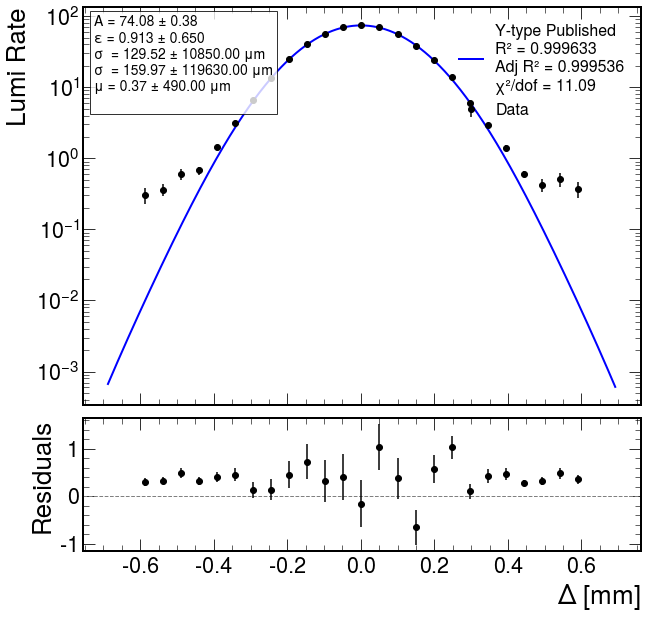

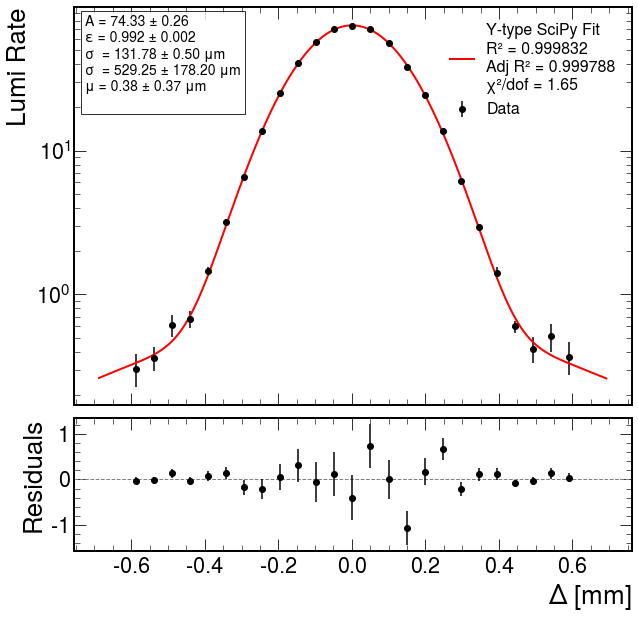


Comparison Table for Y-type Scan:
Parameter       Published       Pub SD    SciPy Fit       Fit SD      Δ (Fit-Pub)         Δ SD
----------------------------------------------------------------------------------------------
A                   74.08         0.38        74.33         0.26             0.25         0.12
ε                    0.91         0.65         0.99         0.00             0.08         0.65
σ₁ (μm)            129.52        10.85       131.78         0.50             2.26        10.35
σ₂ (μm)            159.97       119.63       529.25       178.20           369.28       -58.57
μ (μm)               0.37         0.49         0.38         0.37             0.01         0.12


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import json
from scipy.optimize import curve_fit

# Use CMS style for plotting
plt.style.use(hep.style.CMS)

# ------------------------------
# Define goodness-of-fit functions
# ------------------------------
def compute_chi2(y_true, y_pred, y_err, n_params):
    chi2 = np.sum(((y_true - y_pred) / y_err)**2)
    ndof = len(y_true) - n_params
    return chi2, ndof, chi2/ndof

def compute_RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def compute_R2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

def compute_adj_R2(y_true, y_pred, n_params):
    R2 = compute_R2(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - R2)*(n-1)/(n - n_params - 1)

# ------------------------------
# Define the double Gaussian function (Eq. 33)
# ------------------------------
def double_gaussian(x, A, eps, sigma1, sigma2, mu, C):
    """
    f^{DG}(Δ) = A * [ eps * exp(-((Δ - mu)^2/(2σ₁^2))) +
                       (1 - eps) * exp(-((Δ - mu)^2/(2σ₂^2))) ] + C
    Parameters:
      A      : Overall amplitude.
      eps    : Weight of the first Gaussian (0 < eps < 1).
      sigma1 : Width of the first Gaussian (in mm).
      sigma2 : Width of the second Gaussian (in mm).
      mu     : Common center (in mm).
      C      : Constant offset.
    """
    return C + A * (eps * np.exp(-((x - mu)**2)/(2*sigma1**2)) +
                    (1-eps) * np.exp(-((x - mu)**2)/(2*sigma2**2)))

# ------------------------------
# Plotting function
# ------------------------------
def plot_fit_and_residuals(x, y, y_err, func, params, p_err, label, color, residuals,
                           chi2ndof, RMSE, R2, adj_R2):
    x_plot = np.linspace(x.min()-0.1, x.max()+0.1, 1000)
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(10,10),
                                         gridspec_kw={'height_ratios': [3,1]}, sharex=True)
    fig.subplots_adjust(hspace=0.05)
    
    # Top panel: Plot data and fit curve with legend showing goodness-of-fit metrics (each on a new line)
    ax_top.errorbar(x, y, yerr=y_err, fmt='o', color='black', label="Data")
    fit_label = (f"{label}\n"
                 f"R² = {R2:.6f}\n"
                 f"Adj R² = {adj_R2:.6f}\n"
                 f"χ²/dof = {chi2ndof:.2f}")
    ax_top.plot(x_plot, func(x_plot, *params), lw=2, color=color, label=fit_label)
    ax_top.set_yscale("log")
    ax_top.set_ylabel("Lumi Rate")
    ax_top.legend(loc="upper right", fontsize=16)
    
    # Upper left text box: display parameter values with ± uncertainties.
    textstr = (f"A = {params[0]:.2f} ± {p_err[0]:.2f}\n"
               f"ε = {params[1]:.3f} ± {p_err[1]:.3f}\n"
               f"σ₁ = {params[2]*1000:.2f} ± {p_err[2]*1000:.2f} μm\n"
               f"σ₂ = {params[3]*1000:.2f} ± {p_err[3]*1000:.2f} μm\n"
               f"μ = {params[4]*1000:.2f} ± {p_err[4]*1000:.2f} μm\n"
               f"Const = {params[5]:.2f} ± {p_err[5]:.2f}")
    
    ax_top.text(0.02, 0.98, textstr, transform=ax_top.transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    
    # Bottom panel: Plot residuals.
    ax_bot.axhline(0, color='gray', lw=1, linestyle='--')
    ax_bot.errorbar(x, residuals, yerr=y_err, fmt='o', color='black')
    ax_bot.set_xlabel("$\\Delta$ [mm]")
    ax_bot.set_ylabel("Residuals")
    plt.show()

def params_to_dict(p):
    return {
        "A": p[0],
        "ε": p[1],
        "σ₁ (μm)": p[2]*1000,
        "σ₂ (μm)": p[3]*1000,
        "μ (μm)": p[4]*1000,
        "Const": p[5]
    }

def errors_to_dict(p_err):
    return {
        "A": p_err[0],
        "ε": p_err[1],
        "σ₁ (μm)": p_err[2]*1000,
        "σ₂ (μm)": p_err[3]*1000,
        "μ (μm)": p_err[4]*1000,
        "Const": p_err[5]
    }

# ------------------------------
# Analysis function for a given scan
# ------------------------------
def analyze_scan(file, p_manual, published_params, published_err, scan_label):
    # Load data
    with open(file, "r") as f:
        loaded = json.load(f)
    data = np.array(loaded["data"])
    x = data[:, 0]
    y = data[:, 1]
    y_err = data[:, 2]
    
    # Manual (Published) curve using published parameters
    y_manual = double_gaussian(x, *p_manual)
    chi2_man, ndof_man, chi2ndof_man = compute_chi2(y, y_manual, y_err, len(p_manual))
    RMSE_man = compute_RMSE(y, y_manual)
    R2_man = compute_R2(y, y_manual)
    adj_R2_man = compute_adj_R2(y, y_manual, len(p_manual))
    
    # SciPy Free Fit
    p0 = p_manual.copy()
    bounds_lower = [0, 0, 0, 0, -np.inf, -np.inf]
    bounds_upper = [np.inf, 1, np.inf, np.inf, np.inf, np.inf]
    popt, pcov = curve_fit(double_gaussian, x, y, sigma=y_err, absolute_sigma=True,
                           p0=p0, bounds=(bounds_lower, bounds_upper))
    y_fit = double_gaussian(x, *popt)
    chi2_fit, ndof_fit, chi2ndof_fit = compute_chi2(y, y_fit, y_err, len(popt))
    RMSE_fit = compute_RMSE(y, y_fit)
    R2_fit = compute_R2(y, y_fit)
    adj_R2_fit = compute_adj_R2(y, y_fit, len(popt))
    perr = np.sqrt(np.diag(pcov))
    
    # Plot Manual (Published)
    res_manual = y - y_manual
    # Use published errors (from published_err list)
    p_err_manual = np.array(published_err)
    plot_fit_and_residuals(x, y, y_err, double_gaussian, p_manual,
                           p_err_manual, f"{scan_label} Published", "blue",
                           res_manual, chi2ndof_man, RMSE_man, R2_man, adj_R2_man)
    
    # Plot SciPy Free Fit
    res_fit = y - y_fit
    plot_fit_and_residuals(x, y, y_err, double_gaussian, popt,
                           perr, f"{scan_label} SciPy Fit", "red",
                           res_fit, chi2ndof_fit, RMSE_fit, R2_fit, adj_R2_fit)
    
    # Print Comparison Table with an extra column for difference between published SD and free-fit SD
    free_dict = params_to_dict(popt)
    free_err_dict = errors_to_dict(perr)
    
    print(f"\nComparison Table for {scan_label} Scan:")
    header = f"{'Parameter':<12} {'Published':>12} {'Pub SD':>12} {'SciPy Fit':>12} {'Fit SD':>12} {'Δ (Fit-Pub)':>16} {'Δ SD':>12}"
    print(header)
    print("-"*len(header))
    for key in published_params:
        pub_val, pub_sd = published_params[key]
        free_val = free_dict[key]
        free_sd = free_err_dict[key]
        diff = free_val - pub_val
        diff_sd = pub_sd - free_sd
        print(f"{key:<12} {pub_val:12.2f} {pub_sd:12.2f} {free_val:12.2f} {free_sd:12.2f} {diff:16.2f} {diff_sd:12.2f}")

# ------------------------------
# Published parameters and errors for X-type scan
# ------------------------------
p_manual_x = [73.63, 0.944, 136.34/1000, 136.34/1000, -0.75/1000, 0.42]
published_x = {
    "A": (73.63, 0.35),
    "ε": (0.944, 254650),
    "σ₁ (μm)": (136.34, 443515),
    "σ₂ (μm)": (136.34, 741441),
    "μ (μm)": (-0.75, 0.50),
    "Const": (0.42, 0.05)
}
published_x_err = [0.35, 254650, 443515/1000, 741441/1000, 0.50/1000, 0.05]

# ------------------------------
# Published parameters and errors for Y-type scan
# ------------------------------
p_manual_y = [74.08, 0.913, 129.52/1000, 159.97/1000, 0.37/1000, 0.34]
published_y = {
    "A": (74.08, 0.38),
    "ε": (0.913, 0.65),
    "σ₁ (μm)": (129.52, 10.85),
    "σ₂ (μm)": (159.97, 119.63),
    "μ (μm)": (0.37, 0.49),
    "Const": (0.34, 0.08)
}
published_y_err = [0.38, 0.65, 10.85, 119.63, 0.49, 0.08]

# ------------------------------
# Run analysis for both scans
# ------------------------------
print("Analyzing X-type scan:")
analyze_scan("lumi_preliminary_data_x-type.json", p_manual_x, published_x, published_x_err, "X-type")

print("\nAnalyzing Y-type scan:")
analyze_scan("lumi_preliminary_data_y-type.json", p_manual_y, published_y, published_y_err, "Y-type")
